<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Ardalan Gerami

**Student ID**: 99102112

## Importing the necessary packages

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Creating the Deep Q Network

In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        actions = self.fc3(F.relu(self.fc2(F.relu(self.fc1(state)))))
        return actions

## Creating the Agent

In [3]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    
    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    
    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        if self.epsilon < np.random.random():
            state = T.tensor([observation]).to(self.Q_eval.device)
            action = T.argmax(self.Q_eval.forward(state)).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        batch = np.random.choice(min(self.mem_cntr, self.mem_size),self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval.forward(state_batch)[np.arange(self.batch_size, dtype=np.int32),action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        
        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

## Working with the Maze environment

In [4]:
from maze import MazeEnvironment
import warnings
warnings.filterwarnings('ignore')

# I've defined a function to easily achieve to maximum score
def run_experiment(batch_size, epsilon, gamma, lr, n_games):
    env = MazeEnvironment(dim=50, maze_path='mazes/maze1.npy')

    agent = Agent(gamma=gamma, epsilon=epsilon, batch_size=batch_size, n_actions=4, eps_end=0.2, input_dims=[2], lr=lr)
    scores = []
    eps_history = []
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        counter = 0
        while not done:
            counter += 1
            # If performed 1000 moves and didn't finish the maze, reset the environment
            if counter == 1000:
                observation = env.reset()
                break
            # Make the agent choose an action
            action = agent.choose_action(observation)
            # Retrieve the reward and next_state from the envirinment
            observation_, reward, done = env.step(action)
            # Retrieve the reward and next_state from the envirinment
            score += reward
            # Store the current episode in the memory
            agent.store_transition(observation, action, reward, observation_, done)
            # Learn the current episode
            agent.learn()
            # Change the next state to the current state
            observation = observation_
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        print(f'episode {i}, score {score:.2f}, average score {avg_score:.2f}, epsilon {agent.epsilon:.2f}')
    return scores, avg_score

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.
    * It has been done by up code in a for loop with different experiments.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.
    * It has been done in below code:

In [14]:
# my extra code to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score
# by changing batch size
experiments = [
    {'batch_size': 4, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 100},
    {'batch_size': 8, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 100},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 100},
    {'batch_size': 20, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 100}
]
diff_scores = []
avg_scores = []
for exp in experiments:
    print(f"Running experiment with batch_size={exp['batch_size']}, epsilon={exp['epsilon']}, gamma={exp['gamma']}, lr={exp['lr']}, n_games={exp['n_games']}")
    scores, avg_score = run_experiment(batch_size=exp['batch_size'], epsilon=exp['epsilon'], gamma=exp['gamma'], lr=exp['lr'], n_games=exp['n_games'])
    diff_scores.append(scores)
    avg_scores.append(avg_score)


Running experiment with batch_size=4, epsilon=1.0, gamma=0.99, lr=0.001, n_games=100
episode 0, score 980.00, average score 980.00, epsilon 0.50
episode 1, score 582.00, average score 781.00, epsilon 0.20
episode 2, score 273.00, average score 611.67, epsilon 0.20
episode 3, score 269.00, average score 526.00, epsilon 0.20
episode 4, score 396.00, average score 500.00, epsilon 0.20
episode 5, score 496.00, average score 499.33, epsilon 0.20
episode 6, score 521.00, average score 502.43, epsilon 0.20
episode 7, score 1804.00, average score 665.12, epsilon 0.20
episode 8, score 750.00, average score 674.56, epsilon 0.20
episode 9, score 1574.00, average score 764.50, epsilon 0.20
episode 10, score 78.00, average score 702.09, epsilon 0.20
episode 11, score 246.00, average score 664.08, epsilon 0.20
episode 12, score 1640.00, average score 739.15, epsilon 0.20
episode 13, score 3656.00, average score 947.50, epsilon 0.20
episode 14, score 1848.00, average score 1007.53, epsilon 0.20
episo

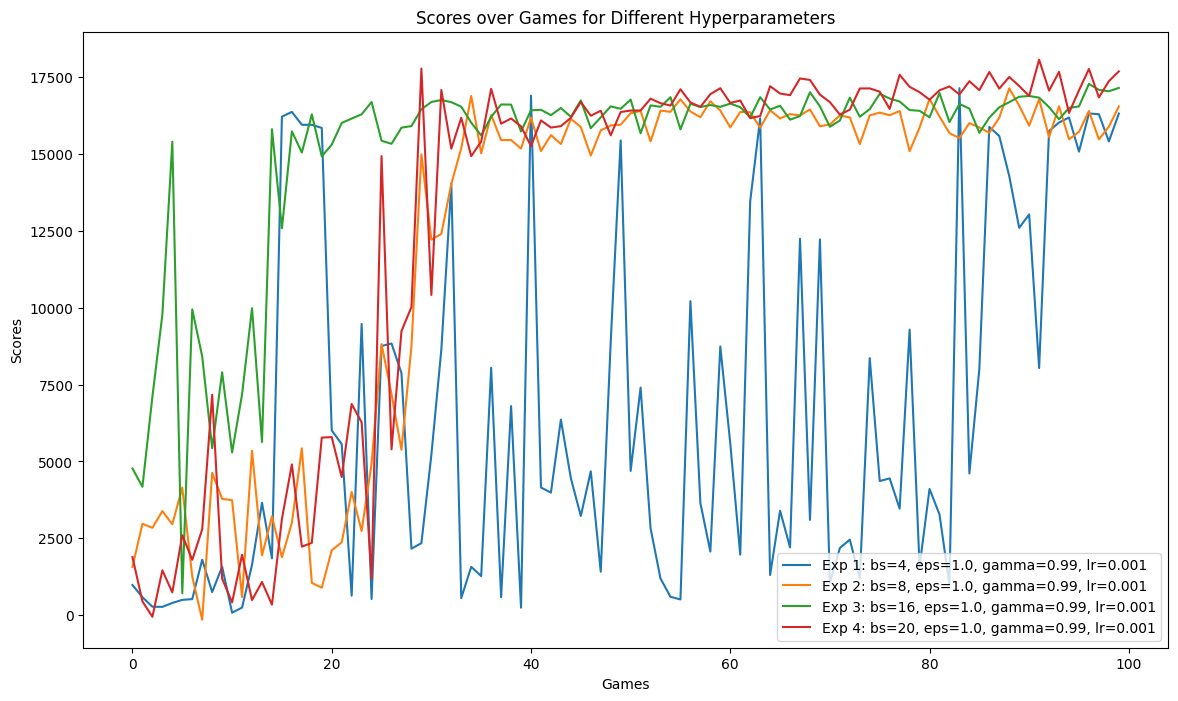

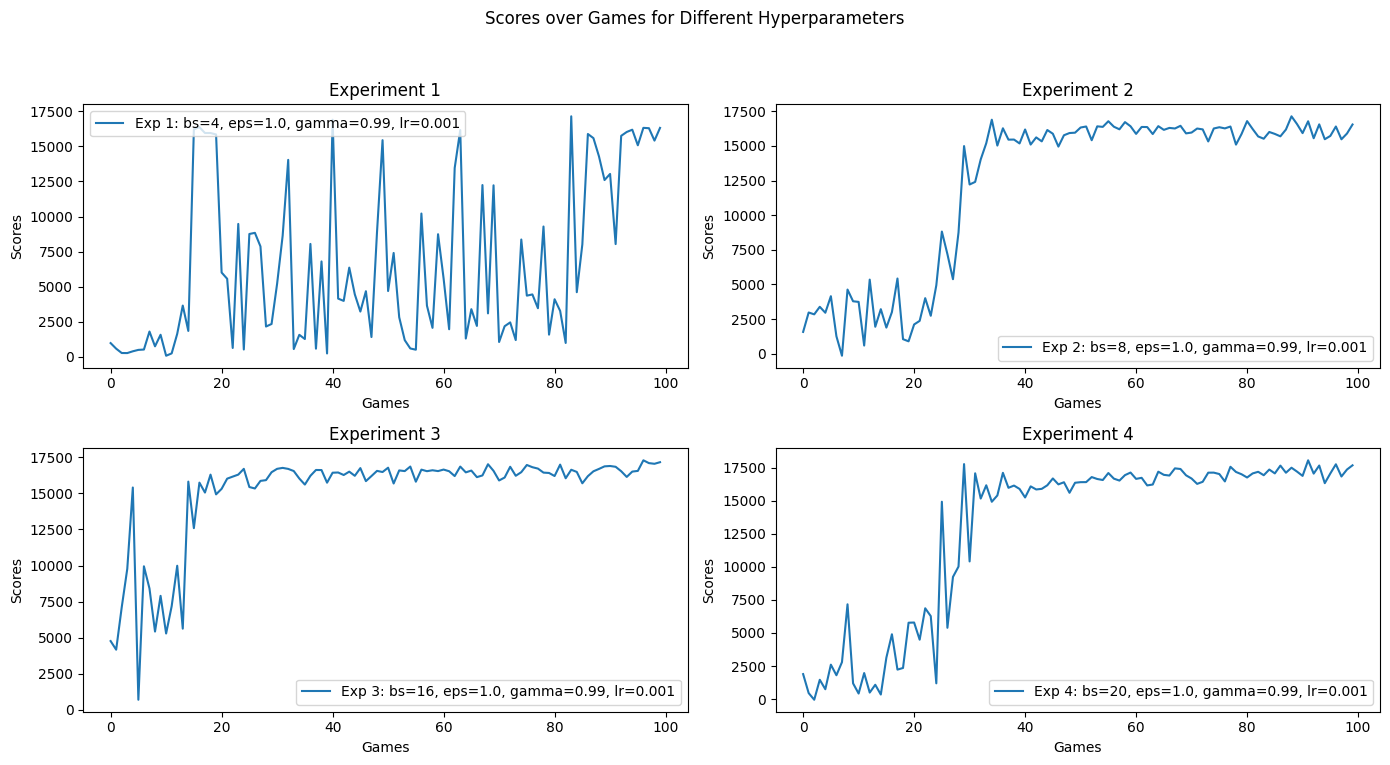

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
for idx, scores in enumerate(diff_scores):
    ax = axes[idx]
    ax.plot(scores, label=f'Exp {idx+1}: bs={experiments[idx]["batch_size"]}, eps={experiments[idx]["epsilon"]}, gamma={experiments[idx]["gamma"]}, lr={experiments[idx]["lr"]}')
    ax.set_xlabel('Games')
    ax.set_ylabel('Scores')
    ax.set_title(f'Experiment {idx+1}')
    ax.legend()

plt.suptitle('Scores over Games for Different Hyperparameters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


- Explanation = As we can see by increasing catch size the behaviour of the score will be more ascending. also after a few games, the score fluctuations will decrease.

In [13]:
# by changing epsilon
experimentsr2 = [
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 90},
    {'batch_size': 16, 'epsilon': 0.8, 'gamma': 0.99, 'lr': 0.001, 'n_games': 90},
    {'batch_size': 16, 'epsilon': 0.7, 'gamma': 0.99, 'lr': 0.001, 'n_games': 90},
    {'batch_size': 16, 'epsilon': 0.6, 'gamma': 0.99, 'lr': 0.001, 'n_games': 90}
]
diff_scores1 = []
avg_scores = []
for exp in experimentsr2:
    print(f"Running experiment with batch_size={exp['batch_size']}, epsilon={exp['epsilon']}, gamma={exp['gamma']}, lr={exp['lr']}, n_games={exp['n_games']}")
    scores1, avg_score = run_experiment(batch_size=exp['batch_size'], epsilon=exp['epsilon'], gamma=exp['gamma'], lr=exp['lr'], n_games=exp['n_games'])
    diff_scores1.append(scores1)

Running experiment with batch_size=16, epsilon=1.0, gamma=0.99, lr=0.001, n_games=90
episode 0, score 4347.00, average score 4347.00, epsilon 0.51
episode 1, score 519.00, average score 2433.00, epsilon 0.20
episode 2, score 1904.00, average score 2256.67, epsilon 0.20
episode 3, score 515.00, average score 1821.25, epsilon 0.20
episode 4, score 2480.00, average score 1953.00, epsilon 0.20
episode 5, score 268.00, average score 1672.17, epsilon 0.20
episode 6, score 816.00, average score 1549.86, epsilon 0.20
episode 7, score 188.00, average score 1379.62, epsilon 0.20
episode 8, score 1944.00, average score 1442.33, epsilon 0.20
episode 9, score 2216.00, average score 1519.70, epsilon 0.20
episode 10, score 1941.00, average score 1558.00, epsilon 0.20
episode 11, score 4148.00, average score 1773.83, epsilon 0.20
episode 12, score 1536.00, average score 1755.54, epsilon 0.20
episode 13, score 1866.00, average score 1763.43, epsilon 0.20
episode 14, score 4174.00, average score 1924.13

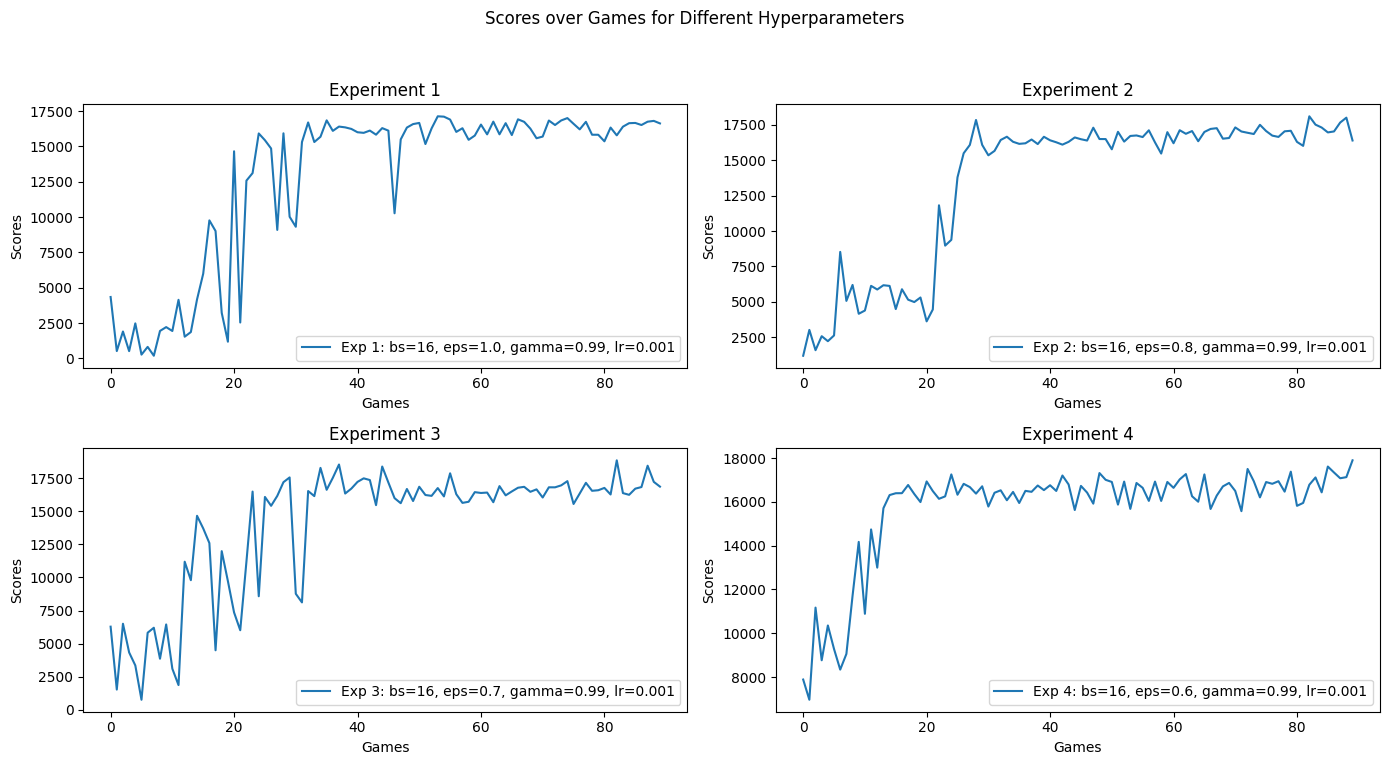

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for idx, scores1 in enumerate(diff_scores1):
    ax = axes[idx]
    ax.plot(scores1, label=f'Exp {idx+1}: bs={experimentsr2[idx]["batch_size"]}, eps={experimentsr2[idx]["epsilon"]}, gamma={experimentsr2[idx]["gamma"]}, lr={experimentsr2[idx]["lr"]}')
    ax.set_xlabel('Games')
    ax.set_ylabel('Scores')
    ax.set_title(f'Experiment {idx+1}')
    ax.legend()

plt.suptitle('Scores over Games for Different Hyperparameters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()

- Explanation = As we can see by decreaing epsilon the score fluctuations will decrease.

In [5]:
# by gamma
experimentsr3 = [
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.89, 'lr': 0.001, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.79, 'lr': 0.001, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.69, 'lr': 0.001, 'n_games': 60}
]
diff_scores3 = []
avg_scores = []
for exp in experimentsr3:
    print(f"Running experiment with batch_size={exp['batch_size']}, epsilon={exp['epsilon']}, gamma={exp['gamma']}, lr={exp['lr']}, n_games={exp['n_games']}")
    scores3, avg_score = run_experiment(batch_size=exp['batch_size'], epsilon=exp['epsilon'], gamma=exp['gamma'], lr=exp['lr'], n_games=exp['n_games'])
    diff_scores3.append(scores3)

Running experiment with batch_size=16, epsilon=1.0, gamma=0.99, lr=0.001, n_games=60
episode 0, score 343.00, average score 343.00, epsilon 0.51
episode 1, score 976.00, average score 659.50, epsilon 0.20
episode 2, score 133.00, average score 484.00, epsilon 0.20
episode 3, score 2910.00, average score 1090.50, epsilon 0.20
episode 4, score 13585.00, average score 3589.40, epsilon 0.20
episode 5, score 6808.00, average score 4125.83, epsilon 0.20
episode 6, score 8752.00, average score 4786.71, epsilon 0.20
episode 7, score 5105.00, average score 4826.50, epsilon 0.20
episode 8, score 14425.00, average score 5893.00, epsilon 0.20
episode 9, score 13067.00, average score 6610.40, epsilon 0.20
episode 10, score 6028.00, average score 6557.45, epsilon 0.20
episode 11, score 13154.00, average score 7107.17, epsilon 0.20
episode 12, score 14608.00, average score 7684.15, epsilon 0.20
episode 13, score 17541.00, average score 8388.21, epsilon 0.20
episode 14, score 8134.00, average score 83

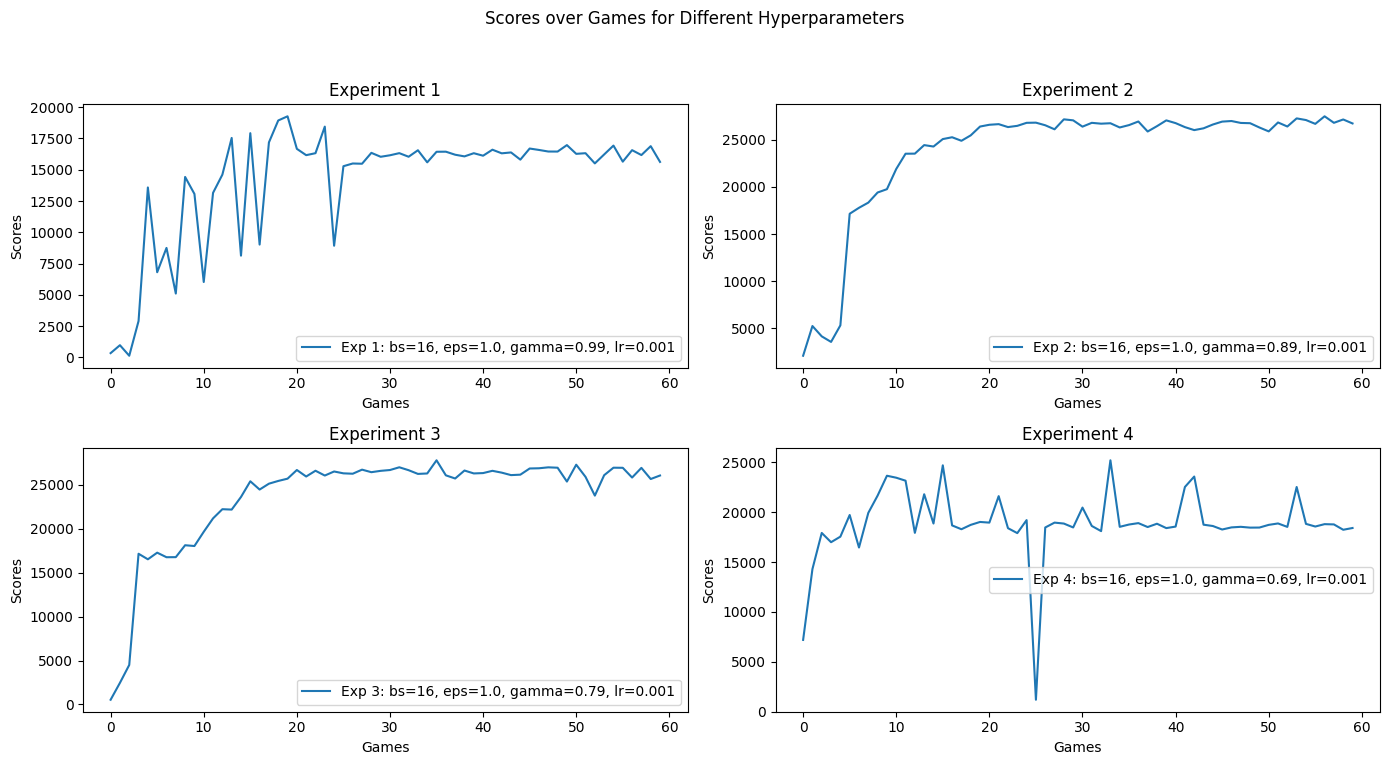

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
for idx, scores3 in enumerate(diff_scores3):
    ax = axes[idx]
    ax.plot(scores3, label=f'Exp {idx+1}: bs={experimentsr3[idx]["batch_size"]}, eps={experimentsr3[idx]["epsilon"]}, gamma={experimentsr3[idx]["gamma"]}, lr={experimentsr3[idx]["lr"]}')
    ax.set_xlabel('Games')
    ax.set_ylabel('Scores')
    ax.set_title(f'Experiment {idx+1}')
    ax.legend()

plt.suptitle('Scores over Games for Different Hyperparameters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()

- Explanation = As we can see by increasing gamma behaviour of the score will be less ascending. also we can't exactly say what will happen to the fluctuations of scores.

In [8]:
# by learning rate
experimentsr4 = [
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.01, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.001, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.0001, 'n_games': 60},
    {'batch_size': 16, 'epsilon': 1.0, 'gamma': 0.99, 'lr': 0.00001, 'n_games': 60}
]
diff_scores4 = []
avg_scores = []
for exp in experimentsr4:
    print(f"Running experiment with batch_size={exp['batch_size']}, epsilon={exp['epsilon']}, gamma={exp['gamma']}, lr={exp['lr']}, n_games={exp['n_games']}")
    scores4, avg_score = run_experiment(batch_size=exp['batch_size'], epsilon=exp['epsilon'], gamma=exp['gamma'], lr=exp['lr'], n_games=exp['n_games'])
    diff_scores4.append(scores4)

Running experiment with batch_size=16, epsilon=1.0, gamma=0.99, lr=0.01, n_games=60
episode 0, score 3299.00, average score 3299.00, epsilon 0.51
episode 1, score 664.00, average score 1981.50, epsilon 0.20
episode 2, score 631.00, average score 1531.33, epsilon 0.20
episode 3, score 1227.00, average score 1455.25, epsilon 0.20
episode 4, score 4172.00, average score 1998.60, epsilon 0.20
episode 5, score 329.00, average score 1720.33, epsilon 0.20
episode 6, score 337.00, average score 1522.71, epsilon 0.20
episode 7, score -29.00, average score 1328.75, epsilon 0.20
episode 8, score 157.00, average score 1198.56, epsilon 0.20
episode 9, score 3297.00, average score 1408.40, epsilon 0.20
episode 10, score 924.00, average score 1364.36, epsilon 0.20
episode 11, score 109.00, average score 1259.75, epsilon 0.20
episode 12, score 369.00, average score 1191.23, epsilon 0.20
episode 13, score 1313.00, average score 1199.93, epsilon 0.20
episode 14, score 1159.00, average score 1197.20, eps

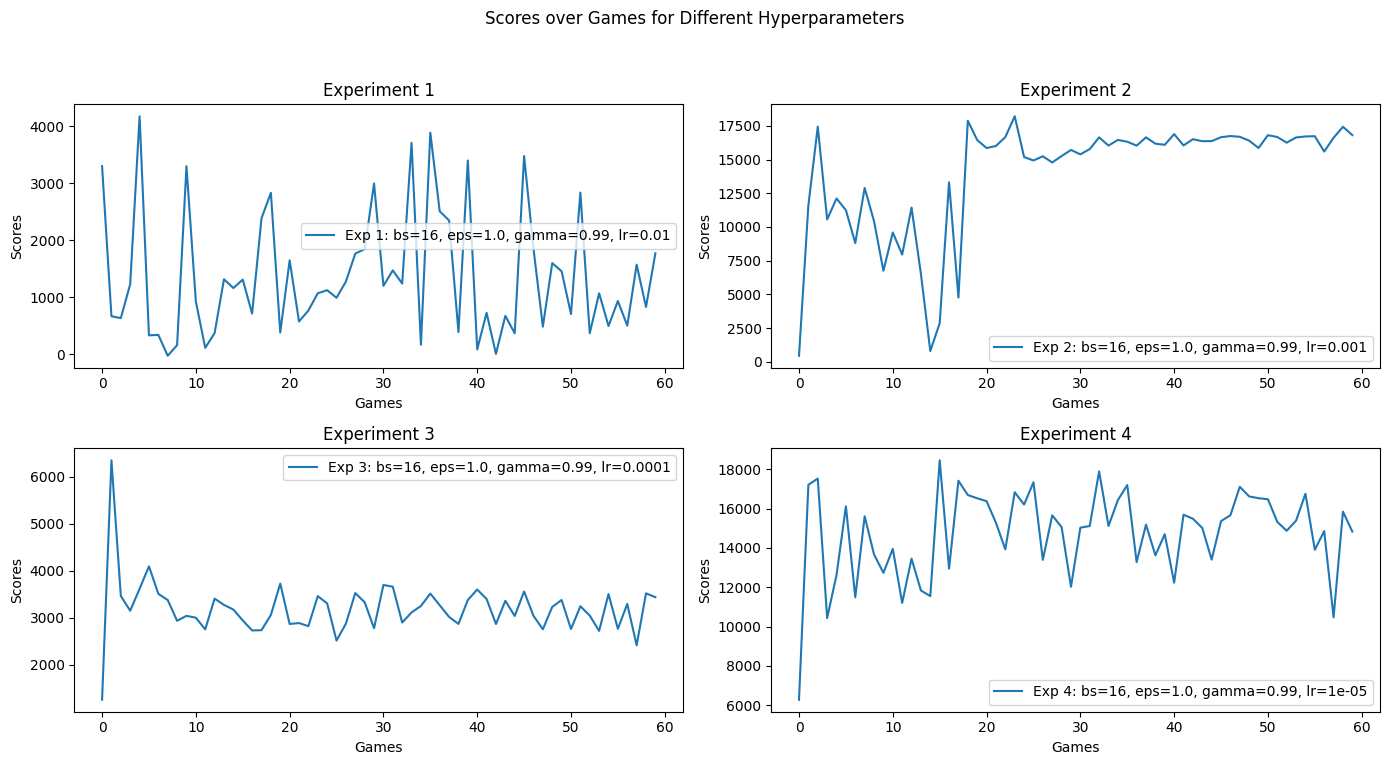

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
for idx4, scores4 in enumerate(diff_scores4):
    ax = axes[idx4]
    ax.plot(scores4, label=f'Exp {idx4+1}: bs={experimentsr4[idx4]["batch_size"]}, eps={experimentsr4[idx4]["epsilon"]}, gamma={experimentsr4[idx4]["gamma"]}, lr={experimentsr4[idx4]["lr"]}')
    ax.set_xlabel('Games')
    ax.set_ylabel('Scores')
    ax.set_title(f'Experiment {idx4+1}')
    ax.legend()

plt.suptitle('Scores over Games for Different Hyperparameters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()

- Explanation = As we can see by deacrising learning rate behaviour of the score will be less ascending for first number of games, it means that we have to see ascending behaviour in high number of games. also we can't exactly say what will happen to the fluctuations of scores.